# LUCID PyTorch

In this example, we train a simple pytorch classifier on the UCI Adult income data set, and generate canonical sets via inverse design.

In [1]:
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader

from canonical_sets.data import Adult, DataSet
from canonical_sets.models import ClassifierPT
from canonical_sets import LUCID

We train the classifier with the adam optimizer and a cross-entropy loss function. We assess the model's performance via the test set.

In [2]:
torch.manual_seed(42)

data = Adult()

train_dataset = DataSet(data.train_data, data.train_labels)
test_dataset = DataSet(data.test_data, data.test_labels)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = ClassifierPT(104, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(2):
    for x, y in train_dl:
        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

num_correct = 0
num_samples = 0

model.eval()

with torch.no_grad():
    for x, y in test_dl:
        scores = model(x)
        predictions = scores.argmax(1)
        num_correct += (predictions == y.argmax(1)).sum()
        num_samples += predictions.size(0)

print(float(num_correct) / float(num_samples) * 100)

82.80212483399735


We use the training data as the example (note that this is the training data which has already been pre-processed), and set the outputs to be a probability of zero for "<=50K" and a probability for one for ">50K". This means that we want to maximize the positive outcome in this case.

In [3]:
example_data = data.train_data
outputs = pd.DataFrame([[0, 1]], columns=["<=50K", ">50K"])

example_data.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass+Federal-gov,Workclass+Local-gov,Workclass+Private,Workclass+Self-emp-inc,Workclass+Self-emp-not-inc,Workclass+State-gov,Workclass+Without-pay,Education+10th,Education+11th,Education+12th,Education+1st-4th,Education+5th-6th,Education+7th-8th,Education+9th,Education+Assoc-acdm,Education+Assoc-voc,Education+Bachelors,Education+Doctorate,Education+HS-grad,Education+Masters,Education+Preschool,Education+Prof-school,Education+Some-college,Martial Status+Divorced,Martial Status+Married-AF-spouse,Martial Status+Married-civ-spouse,Martial Status+Married-spouse-absent,Martial Status+Never-married,Martial Status+Separated,Martial Status+Widowed,Occupation+Adm-clerical,Occupation+Armed-Forces,Occupation+Craft-repair,Occupation+Exec-managerial,...,Country+Canada,Country+China,Country+Columbia,Country+Cuba,Country+Dominican-Republic,Country+Ecuador,Country+El-Salvador,Country+England,Country+France,Country+Germany,Country+Greece,Country+Guatemala,Country+Haiti,Country+Holand-Netherlands,Country+Honduras,Country+Hong,Country+Hungary,Country+India,Country+Iran,Country+Ireland,Country+Italy,Country+Jamaica,Country+Japan,Country+Laos,Country+Mexico,Country+Nicaragua,Country+Outlying-US(Guam-USVI-etc),Country+Peru,Country+Philippines,Country+Poland,Country+Portugal,Country+Puerto-Rico,Country+Scotland,Country+South,Country+Taiwan,Country+Thailand,Country+Trinadad&Tobago,Country+United-States,Country+Vietnam,Country+Yugoslavia
0,0.123288,-0.950895,0.066667,-1.0,-1.000000,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-0.726027,-0.621532,0.066667,-1.0,-1.000000,-0.102041,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,-0.150685,-0.874857,-0.466667,-1.0,-1.000000,-0.204082,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,-0.561644,-0.787375,0.066667,-1.0,-1.000000,-0.102041,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,-0.013699,-0.694464,0.333333,-1.0,-0.318182,-0.204082,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


We run the gradient-based inverse design with the default settings. 

In [4]:
lucid = LUCID(model, outputs, example_data)
lucid.results.head(12)

100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


<=50K      >50K  ...  Country+Vietnam  Country+Yugoslavia
sample epoch                      ...                                     
1      1      0.946791  0.053209  ...                0                   0
       200    0.004568  0.995432  ...                0                   0
       201    0.174813  0.825187  ...                0                   0
2      1      0.434737  0.565263  ...                0                   0
       200    0.004351  0.995649  ...                0                   0
       201    0.525234  0.474766  ...                0                   0
3      1      0.079332  0.920668  ...                0                   0
       200    0.004152  0.995848  ...                0                   0
       201    0.417292  0.582708  ...                0                   0
4      1      0.703180  0.296820  ...                0                   0
       200    0.004397  0.995603  ...                0                   0
       201    0.285513  0.714487  ...                0                   0

[12 rows x 106 columns]

Using the pandas multi-index you can select by epoch or sample.

In [5]:
lucid.results.query("sample == 1")

<=50K      >50K  ...  Country+Vietnam  Country+Yugoslavia
sample epoch                      ...                                     
1      1      0.946791  0.053209  ...                0                   0
       200    0.004568  0.995432  ...                0                   0
       201    0.174813  0.825187  ...                0                   0

[3 rows x 106 columns]

In [6]:
lucid.results.query("epoch == 1")

,,<=50K,>50K,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass+Federal-gov,Workclass+Local-gov,Workclass+Private,Workclass+Self-emp-inc,Workclass+Self-emp-not-inc,Workclass+State-gov,Workclass+Without-pay,Education+10th,Education+11th,Education+12th,Education+1st-4th,Education+5th-6th,Education+7th-8th,Education+9th,Education+Assoc-acdm,Education+Assoc-voc,Education+Bachelors,Education+Doctorate,Education+HS-grad,Education+Masters,Education+Preschool,Education+Prof-school,Education+Some-college,Martial Status+Divorced,Martial Status+Married-AF-spouse,Martial Status+Married-civ-spouse,Martial Status+Married-spouse-absent,Martial Status+Never-married,Martial Status+Separated,Martial Status+Widowed,Occupation+Adm-clerical,Occupation+Armed-Forces,...,Country+Canada,Country+China,Country+Columbia,Country+Cuba,Country+Dominican-Republic,Country+Ecuador,Country+El-Salvador,Country+England,Country+France,Country+Germany,Country+Greece,Country+Guatemala,Country+Haiti,Country+Holand-Netherlands,Country+Honduras,Country+Hong,Country+Hungary,Country+India,Country+Iran,Country+Ireland,Country+Italy,Country+Jamaica,Country+Japan,Country+Laos,Country+Mexico,Country+Nicaragua,Country+Outlying-US(Guam-USVI-etc),Country+Peru,Country+Philippines,Country+Poland,Country+Portugal,Country+Puerto-Rico,Country+Scotland,Country+South,Country+Taiwan,Country+Thailand,Country+Trinadad&Tobago,Country+United-States,Country+Vietnam,Country+Yugoslavia
sample,epoch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0.946791,0.053209,0.953400,-0.239609,0.846492,-0.476615,-0.361806,-0.763818,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0.434737,0.565263,-0.008990,0.521141,0.374523,-0.503690,0.244093,-0.368689,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0.079332,0.920668,0.461862,0.364942,0.525183,0.198825,-0.529045,-0.943877,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0.703180,0.296820,-0.290496,-0.508702,-0.064275,0.552951,-0.922651,0.564081,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0.336834,0.663167,0.631150,-0.486036,-0.960426,-0.393935,-0.271197,0.217928,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0.997092,0.002908,-0.243961,-0.747192,0.047886,0.942131,-0.474525,0.557954,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
97,1,0.355176,0.644824,0.719518,-0.812895,-0.828304,0.721479,0.955049,0.709456,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98,1,0.451687,0.548313,0.901062,0.068491,-0.799558,0.374923,0.670941,0.993641,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


We can also select certain categorical features by using pandas.

In [7]:
lucid.results.query("sample == 1").loc[:, lucid.results.columns.str.startswith("Workclass")]

Workclass+Federal-gov  ...  Workclass+Without-pay
sample epoch                         ...                       
1      1                          0  ...                      0
       200                        0  ...                      0
       201                        0  ...                      0

[3 rows x 7 columns]

The results are not yet transformed back to their original range and can therefore be difficult to interpret. To make this easier, we can apply the transform_results method and provide the original sklearn scaler from the data object.

In [8]:
lucid.process_results(data.scaler)

In [9]:
lucid.results_processed.head(12)

<=50K      >50K  ...     Sex      Country
sample epoch                      ...                     
1      1      0.946791  0.053209  ...    Male  El-Salvador
       200    0.004568  0.995432  ...    Male       Taiwan
       201    0.174813  0.825187  ...    Male       Taiwan
2      1      0.434737  0.565263  ...  Female         Hong
       200    0.004351  0.995649  ...  Female         Hong
       201    0.525234  0.474766  ...  Female         Hong
3      1      0.079332  0.920668  ...    Male         Cuba
       200    0.004152  0.995848  ...    Male         Cuba
       201    0.417292  0.582708  ...    Male         Cuba
4      1      0.703180  0.296820  ...    Male       France
       200    0.004397  0.995603  ...    Male       France
       201    0.285513  0.714487  ...    Male       France

[12 rows x 16 columns]

We can also plot some of the results, such as the predictions of the first and the last epoch. And also after the last epoch is categorically formatted.

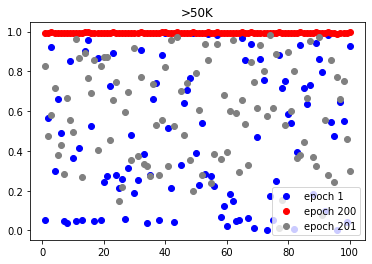

In [10]:
lucid.plot(">50K")

We can also check the distributions of the features in the first and last epochs.

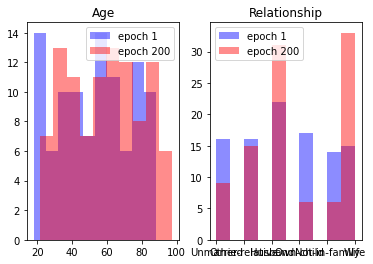

In [11]:
lucid.hist(["Age", "Relationship"])

We can also save the object by pickling.

In [12]:
joblib.dump(lucid, "lucid.pkl")

['lucid.pkl']

In [13]:
lucid = joblib.load("lucid.pkl")